In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pretrained_model = "Early_Work_RH/data/lenet_mnist_model.pth"
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
model = Net().to(device)
model.load_state_dict(torch.load(pretrained_model))
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [5]:
data_set = torchvision.datasets.MNIST('Early_Work_RH/data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
            ]))

In [6]:
dl = torch.utils.data.DataLoader(data_set, batch_size=1, shuffle=False)

In [7]:
for data, label in dl:
    print(data.size())
    break

torch.Size([1, 1, 28, 28])


In [8]:
def test(model, device, dl, epsilon, alpha, steps):
    adversarial_images = []
    correct = 0
    
    for img, label in dl:
        img, label = img.to(device), label.to(device)

        curr_img = img
        curr_img.requires_grad = True
        output = model(curr_img)

        for i in range(steps):
            loss = F.cross_entropy(output, label)

            model.zero_grad()
            loss.backward()

            data_grad = curr_img.grad.data.sign()

            perturbed_image = img + alpha*data_grad

            perturbed_image = torch.clamp(perturbed_image, 0, 1)

            total_grad = perturbed_image - img

            total_grad = torch.clamp(total_grad, -epsilon, epsilon)

            perturbed_image = img + total_grad

            curr_img = perturbed_image.clone().detach()

            curr_img.requires_grad = True

            output = model(curr_img)

        final_pred = output.max(1, keepdim=True)[1]

        if final_pred == label:
            correct += 1
        else:
            adversarial_images.append((perturbed_image.cpu(), label.cpu()))
        
    return correct/len(dl), adversarial_images

In [9]:
epsilon = .5
alpha = .25
num_steps = 5
accuracy, adv_imgs = test(model, device, dl, epsilon, alpha, num_steps)

In [10]:
print(accuracy)
print(len(adv_imgs))
print(adv_imgs[0][0].size())

0.1162
8838
torch.Size([1, 1, 28, 28])


In [11]:
data_set = torchvision.datasets.MNIST('Early_Work_RH/data', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
            ]))
            
dl = torch.utils.data.DataLoader(data_set, batch_size=1, shuffle=False)

In [12]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        return x

In [13]:
model2 = Net2().to(device)
model2.load_state_dict(torch.load(pretrained_model))
model2.eval()

Net2(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [26]:
outputs = np.empty((len(dl)+ len(adv_imgs),50)) #+ len(adv_imgs)
labels = []
x = 0
for img, label in dl:
    img = img.to(device)
    output = model2(img)
    outputs[x] = output.squeeze().tolist()
    labels.append(str(label.item()))
    x += 1

for img, label in adv_imgs:
    img = img.to(device)
    output = model2(img)
    outputs[x] = output.squeeze().tolist()
    labels.append(str(label.item()))
    x += 1

print(outputs.shape)
print(len(labels))


(68838, 50)
68838


In [27]:
print(labels[:5])

['5', '0', '4', '1', '9']


In [28]:
outputs

array([[0.20884892, 0.        , 0.95287186, ..., 0.        , 0.        ,
        0.02699973],
       [0.        , 0.        , 1.45453119, ..., 0.        , 1.13831818,
        1.83717346],
       [1.016734  , 1.20026672, 0.        , ..., 0.        , 0.7739591 ,
        0.        ],
       ...,
       [1.5008682 , 0.        , 0.        , ..., 0.        , 1.0756762 ,
        0.        ],
       [0.25660273, 0.        , 0.        , ..., 0.        , 0.14622256,
        0.48842752],
       [0.        , 0.03959019, 0.        , ..., 0.1832943 , 0.        ,
        0.31527224]])

In [29]:
import time
import seaborn as sns
from sklearn import manifold
from sklearn.manifold import TSNE
import pandas as pd

In [30]:
time_start = time.time()
tsne2d = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne2d_results = tsne2d.fit_transform(outputs)
print('t-SNE done in {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 68838 samples in 0.007s...
[t-SNE] Computed neighbors for 68838 samples in 89.375s...
[t-SNE] Computed conditional probabilities for sample 1000 / 68838
[t-SNE] Computed conditional probabilities for sample 2000 / 68838
[t-SNE] Computed conditional probabilities for sample 3000 / 68838
[t-SNE] Computed conditional probabilities for sample 4000 / 68838
[t-SNE] Computed conditional probabilities for sample 5000 / 68838
[t-SNE] Computed conditional probabilities for sample 6000 / 68838
[t-SNE] Computed conditional probabilities for sample 7000 / 68838
[t-SNE] Computed conditional probabilities for sample 8000 / 68838
[t-SNE] Computed conditional probabilities for sample 9000 / 68838
[t-SNE] Computed conditional probabilities for sample 10000 / 68838
[t-SNE] Computed conditional probabilities for sample 11000 / 68838
[t-SNE] Computed conditional probabilities for sample 12000 / 68838
[t-SNE] Computed conditional probabilities for s

In [31]:
tsne2_subset = pd.DataFrame(columns=['tsne-2d-one', 'tsne-2d-two'])

tsne2_subset['tsne-2d-one'] = tsne2d_results[:,0]
tsne2_subset['tsne-2d-two'] = tsne2d_results[:,1]

print(tsne2_subset.head())

   tsne-2d-one  tsne-2d-two
0    -4.237527     1.477033
1     2.095420    -2.308187
2     1.676590    -4.460131
3     2.827414     5.750595
4     5.280159    -3.703181


       principalcomponent1  principalcomponent2 label
0                -4.237527             1.477033     5
1                 2.095420            -2.308187     0
2                 1.676590            -4.460131     4
3                 2.827414             5.750595     1
4                 5.280159            -3.703181     9
...                    ...                  ...   ...
68833            -0.065656             0.710617     1
68834            -1.943064             0.785682     3
68835             0.603796             1.252961     4
68836            -0.144448             2.376179     5
68837            -0.926302            -1.257452     6

[68838 rows x 3 columns]


<Figure size 4320x1440 with 0 Axes>

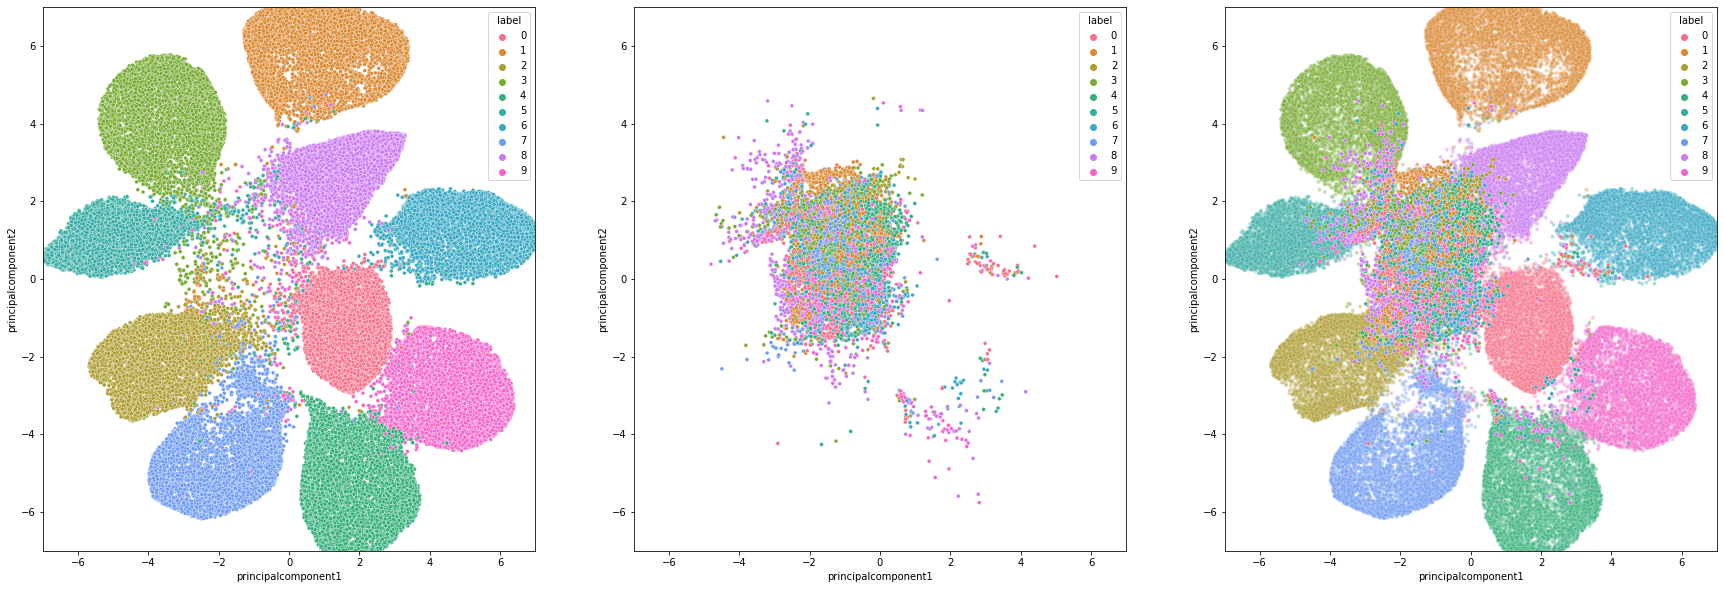

<Figure size 4320x1440 with 0 Axes>

In [32]:
principalDf = pd.concat([tsne2_subset,pd.DataFrame(labels)],axis = 1,join='inner', ignore_index=True)
principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
principalDf.columns = ["principalcomponent1", "principalcomponent2", "label"]

print(principalDf)

hue_order = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig = plt.gcf()
fig.set_size_inches(30,10)

ax1.set_xlim([-7, 7])
ax1.set_ylim([-7, 7])
ax2.set_xlim([-7, 7])
ax2.set_ylim([-7, 7])
ax3.set_xlim([-7, 7])
ax3.set_ylim([-7, 7])

flatui = ["#9b59b6", "#3498db", "orange"]
sns.set_palette(flatui)
sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[:60000], s = 15, hue_order=hue_order,
           hue='label', legend=True, ax=ax1)

sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[60000:], s = 15, hue_order=hue_order,
           hue='label', legend=True, ax=ax2)

sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[:60000], s = 15, alpha = .4, hue_order=hue_order,
           hue='label', legend=True, ax=ax3)

sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[60000:], s = 15, alpha = 1, hue_order=hue_order,
           hue='label', legend=False, ax=ax3)


plt.figure(figsize=(60,20))